Tại sao tôi viết bài viết này? Cách đây hơn 1 năm khi tôi vào Đà Nẵng để chia sẻ ở sự kiện Cloud Next Extended 2018 về làm cách nào để có thể xây dựng một mạng CNN, trên đường đi từ khách sạn đến địa điểm tổ chức sự kiện, tôi nhận thấy trên taxi có một thiết bị luôn giúp tài xế nhận biện các biển báo trên đường.

Tôi thấy thiết bị này khá hữu ích đặc biệt ở Việt Nam đôi khi biển báo nằm trốn sau cây hoặc cột điện. :D. Bài này chúng ta sẽ xây dựng một model để xử lý bài toán này. Ở đây tôi chưa nhắc đến việc làm realtime nhận diện biển báo, mà chỉ xây dựng mô hình deep learning nhận diện thôi. 

**Quan trọng:** Pretrained-model tôi đã train được đính kèm trong thư mục chung với file này. Bạn có thể tham khảo việc sử dụng ở phần 6.

Đây là [link Google Colab](https://drive.google.com/open?id=1v4xCMmEZF8SAJNXLdPrTPBQH-gNqZ6oZ) tôi dùng để train Model: tỉ lệ chính xác của mô hình là 92,25 %. Tại sao lại cao như vậy? Rõ ràng một cách logic rằng bạn có thể nghĩ là khi thiết kế biển báo, người ta luôn cố gắng thiết kế sao cho dễ nhận biết nhất tức là đặc trưng khác nhau lớn giữa các biển báo. Vì vậy sẽ ít xảy ra hiện tượng nhầm lẫn.

Tôi đặt tên mạng này là NgocNet vì là do tôi tự xây dựng lên, khi bạn code theo tôi bạn cũng có thể đặt tên mạng này theo tên riêng của bạn. Ví dụ bạn tên là Quân bạn có thể đặt tên mạng là QuanNet -> Quán Nét. :D


Đây là ảnh một số đặc trưng trong [bộ dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset). Tôi có đính kèm link tải nhanh bộ dataset ở phía dưới.

<img src="img/data.png" width=500/>

#### 1. Thêm các thư viện cần thiết

Như thường lệ, việc đầu tiên là thêm các thư viện cần thiết, Chúng ta sẽ sử dụng Tensorflow 2.0. Nếu bạn chưa cài thì có thể chạy script dưới đây.

In [139]:
# !pip3 install tensorflow-gpu==2.0.0-rc0 

In [140]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate

In [141]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

In [142]:
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [143]:
import pickle
import os

In [144]:
from sklearn.preprocessing import LabelBinarizer

In [145]:
import wget

In [146]:
link = "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"

#### 2. Tải dữ liệu

In [76]:
def bar_custom(current, total, width=80):
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))

In [ ]:
wget.download(link, bar=bar_custom) 

Link Folder lưu dữ liệu

In [147]:
data_folder_link = './signsdata'

Tạo thư mực lưu data

In [148]:
if not os.path.isdir(data_folder_link):
    print('new directry has been created')
    os.system('mkdir {}'.format(data_folder_link))

Unzip vào thư mục data

In [149]:
!unzip -q traffic-signs-data.zip -d $data_folder_link

replace ./signsdata/test.p? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [154]:
train_data_path = data_folder_link + "/train.p"
test_data_path = data_folder_link + "/test.p"
valid_data_path = data_folder_link + "/valid.p"

Sử dụng thư viện Pickle để đọc data

In [193]:
with open(train_data_path, mode="rb") as f:
    train = pickle.load(f)

In [194]:
with open(test_data_path, mode="rb") as f:
    test = pickle.load(f)

In [195]:
with open(valid_data_path, mode="rb") as f:
    valid = pickle.load(f)

Data được lưu dưới dạng {"features":[], "labels": []}

Bộ train được sử dụng cho quá trình huấn luyện

In [196]:
train_X = train["features"]
train_Y = train["labels"]


# Tráo bộ dữ liệu
train_X, train_Y = shuffle(train_X, train_Y)

Tại sao phải tráo bộ dữ liệu hiện tại, bởi vì các ảnh tương đồng nhau đang được liền nhau, cho nên để tăng tính ngẫu nhiên của dữ liệu ta phải tráo chúng lên.

Bộ valid được sử dụng cho quá trình kiểm soát độ chính xác của mô hình khi training

In [197]:
valid_X = valid["features"]
valid_Y = valid["labels"]

# Tráo bộ dữ liệu

valid_X, valid_Y = shuffle(valid_X, valid_Y)

Bộ test được sử dụng để kiểm tra độ chính xác của mô hình sau khi training

In [198]:
test_X = test["features"]
test_Y = test["labels"]

In [199]:
from sklearn.utils import shuffle

Show 1 ảnh từ bộ test

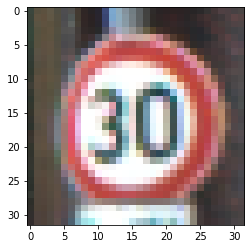

In [200]:
plt.imshow(test_X[1])

Danh sách các nhãn 

In [201]:
classNames = ['Speed limit (20km/h)',
 'Speed limit (30km/h)',
 'Speed limit (50km/h)',
 'Speed limit (60km/h)',
 'Speed limit (70km/h)',
 'Speed limit (80km/h)',
 'End of speed limit (80km/h)',
 'Speed limit (100km/h)',
 'Speed limit (120km/h)',
 'No passing',
 'No passing for vehicles over 3.5 metric tons',
 'Right-of-way at the next intersection',
 'Priority road',
 'Yield',
 'Stop',
 'No vehicles',
 'Vehicles over 3.5 metric tons prohibited',
 'No entry',
 'General caution',
 'Dangerous curve to the left',
 'Dangerous curve to the right',
 'Double curve',
 'Bumpy road',
 'Slippery road',
 'Road narrows on the right',
 'Road work',
 'Traffic signals',
 'Pedestrians',
 'Children crossing',
 'Bicycles crossing',
 'Beware of ice/snow',
 'Wild animals crossing',
 'End of all speed and passing limits',
 'Turn right ahead',
 'Turn left ahead',
 'Ahead only',
 'Go straight or right',
 'Go straight or left',
 'Keep right',
 'Keep left',
 'Roundabout mandatory',
 'End of no passing',
 'End of no passing by vehicles over 3.5 metric tons']

Ví dụ ảnh có nhãn là 1 thì tên của nhãn sẽ classNames[1]. là Cho nên nhãn của ảnh bên trên sẽ là:

In [202]:
classNames[test_Y[1]]

'Speed limit (30km/h)'

Vậy nhãn của chúng ta đã tương ứng với ảnh, đây là biển số không vượt quá tốc độc 30km/h

Hiển thị 25 ảnh ban đầu sau khi xáo trộn dữ liệu

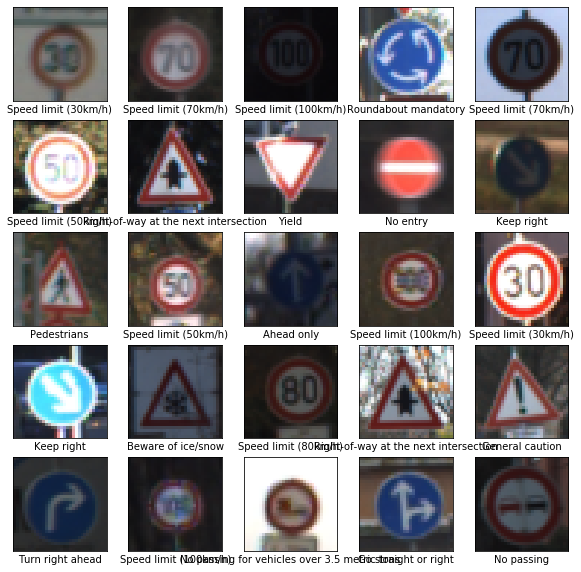

In [203]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_X[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(classNames[train_Y[i]])
plt.show()

#### 3. Chuẩn hoá dữ liệu

Đưa dữ liệu về trong khoảng (0,1). Tại sao phải làm như thế này thì tôi đã giải thích tại bài trước. [Xem ở đây](../setup-and-first-code.ipynb)

In [204]:
train_X = train_X.astype("float") / 255.0
test_X = test_X.astype("float") / 255.0
valid_X = valid_X.astype("float") / 255.0

In [205]:
lb = LabelBinarizer()
train_Y = train_Y.reshape((train_Y.shape[0], 1))

Nhãn được đánh từ 0 đến 42 tương đương với danh sách như bên trên.

Chuyển về dạng one hot.

One hot chỉ là cách chuyển nhãn về sao cho đảm bảo tính tương đồng của các nhãn với nhau. Hình ảnh dưới đây minh hoạ ma trận onehot.



<img src="../img/onehot.jpeg" width=600/>

In [206]:
train_Y = lb.fit_transform(train_Y)
valid_Y = lb.fit_transform(valid_Y)
test_Y = lb.fit_transform(test_Y)

In [207]:
train_Y

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

#### 4. Thiết kế model

<img src="./img/arch.png" />

Chúng ta thực hiện các phép tích chập, phép max-pooling và sau đó đưa vào mạng nửa kết nối đầy đủ (half fully-connected network) và giảm chiều lớp xuống đúng bằng số lượng class.

In [208]:
model = Sequential()

In [209]:
learning_rate = 1e-2
batch_size = 64
num_epochs = 30 # Accuracy: 74% within 30 epochs

In [210]:
width = 32
height = 32
classes = 43

In [211]:
shape = (width,height, 3)

In [212]:
model.add(Conv2D(32, (3 , 3), padding='same', input_shape=shape))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(32, (3 , 3), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

In [213]:
model.add(Conv2D(64, (3 , 3), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Conv2D(64, (3 , 3), padding='same'))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

Đưa vào mạng Neuron không kết nối đầy đủ vì có sử dụng Dropout.

In [214]:
model.add(Flatten())
model.add(Dense(512))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(classes))

In [215]:
model.add(Activation("softmax"))

Kiểm tra lại cấu trúc của mô hình trước khi train.

In [216]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_12 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)       

#### 5. Tăng cường data khi train

Ta có thể xoay, zoom to, thay đổi kích cỡ để có nhiều đặc trưng hơn mà vẫn giữ nguyên nhãn

In [217]:
aug = ImageDataGenerator(rotation_range=18, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

Chỉ số decay nhằm điều chỉnh learning rate. Đọc thêm ở đây https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

In [218]:
opt = SGD(lr=learning_rate, momentum=0.9, decay=learning_rate / num_epochs)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
print("Start Training...")
H = model.fit_generator(aug.flow(train_X, train_Y, batch_size=batch_size), validation_data=(valid_X, valid_Y), 
                        steps_per_epoch=train_X.shape[0] // batch_size, epochs=num_epochs, verbose=1)

#### 6. Lưu model và load lại nhằm inference

Lưu lại model sau khi train xong.

In [ ]:
# model.save('ngocnet.h5')

Trong notebook này, tôi đã train trên Google Colab và sử dụng lại pretrained-model

In [219]:
import tensorflow as tf
import numpy as np

In [220]:
model = tf.keras.models.load_model("ngocnet.h5")

In [228]:
result = model.predict(np.array(test_X[0:1]/255.0))

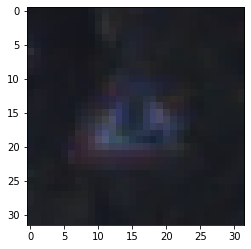

In [229]:
plt.imshow(test_X[50], cmap=plt.cm.binary)

In [227]:
predicted_label = np.argmax(result)

In [224]:
classNames[predicted_label]

'Dangerous curve to the left'

Như bạn đã thấy với một ảnh ngãu nhiên ta đã dự đoán đúng ý nghĩa của biển báo.

Vậy là tôi đã chia sẻ xong cách xây dựng một deep learning model để nhận biết biển báo giao thông. Chia sẻ bài viết này nếu bạn thấy hữu ích nhé.

Thân.